# Data Embedding Techniques for Quantum Machine Learning

## Installation

In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 13.7 MB 24.8 MB/s 
     |████████████████████████████████| 143 kB 47.6 MB/s 
     |████████████████████████████████| 1.9 MB 48.9 MB/s 


In [ ]:
import pennylane as qml
from pennylane import numpy as np

## Basis Encoding

Data Type -> Integer/Binary Values

Encodes $N$ binary features into a basis state of $n$ qubits.

Transformation:

[1,1] --> |11> 

(Binary Values) --> Basis State 

In [ ]:
# basis encoding
wires = range(2) # set num_qubits
basis_dev = qml.device("default.qubit",wires)

@qml.qnode(basis_dev)
def basis_encoder(data):
  qml.BasisEmbedding(data,wires)
  return qml.state()

In [ ]:
basis_encoder(3)

tensor([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j], requires_grad=True)

## Amplitude Encoding

Data Type --> Integer/Float/Complex

Amplitude embedding encodes a normalized 
$2^n$
-dimensional feature vector into the state of 
$n$
 qubits

In [ ]:
# amplitude encoding
wires = range(2) # set num_qubits
amp_dev = qml.device("default.qubit",wires)

@qml.qnode(amp_dev)
def amp_encoder(data):
  qml.AmplitudeEmbedding(data,wires)
  return qml.state()

In [ ]:
amp_encoder([1/np.sqrt(2),1/np.sqrt(2),0,0])

tensor([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j, 0.        +0.j], requires_grad=True)

* When size(data) $\neq 2^n $

In [ ]:
wires = range(2) # set num_qubits
amp_dev = qml.device("default.qubit",wires)

@qml.qnode(amp_dev)
def amp_encoder1(data):
  qml.AmplitudeEmbedding(data,wires,pad_with=0)
  return qml.state()

In [ ]:
amp_encoder1([1/np.sqrt(2),0,1/np.sqrt(2)])

tensor([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j], requires_grad=True)

* When Born's rule is not satisfied:

  * $|\alpha_1|^2 + |\alpha_2|^2 + ..... + |\alpha_N|^2 \neq 1 $

In [ ]:
wires = range(2) # set num_qubits
amp_dev = qml.device("default.qubit",wires)

@qml.qnode(amp_dev)
def amp_encoder2(data):
  qml.AmplitudeEmbedding(data,wires,normalize=True)
  return qml.state()

In [ ]:
amp_encoder2([1.5+1j,2.5,1,1])

tensor([0.44232587+0.29488391j, 0.73720978+0.j        ,
        0.29488391+0.j        , 0.29488391+0.j        ], requires_grad=True)

## Angle Embedding

Data Type --> Int/Float/Complex

Encodes $N$ features into the rotation angles of $n$ qubits, where 
$N \leq n$

Angle embedding encodes the features by using the specified rotation operation.

In [ ]:
wires = range(1) # set num_qubits
angle_dev = qml.device("default.qubit",wires)

@qml.qnode(angle_dev)
def angle_encoder(data):
  qml.AngleEmbedding(features=data,wires=wires,rotation='X')
  return qml.state()

In [ ]:
angle_encoder([1])

tensor([0.87758256+0.j        , 0.        -0.47942554j], requires_grad=True)

In [ ]:
print(qml.draw(qnode=angle_encoder,expansion_strategy="device")([1]))

0: ──RX(1.00)─┤  State


In [ ]:
# This is what actually happens
np.array([[np.cos(1/2), -1j*np.sin(1/2)],[-1j*np.sin(1/2),np.cos(1/2)]]).dot([1,0])

tensor([0.87758256+0.j        , 0.        -0.47942554j], requires_grad=True)

## Displacement Embedding

Data Type --> Int/Float/Complex

Encodes $N$ features into the displacement amplitudes $r$ or phases 
$ϕ$ of $M$ modes, where $N \leq M$.

$$ D(\alpha) = exp(\alpha \hat{a}^{\dagger} - \alpha^*\hat{a}) $$

$\alpha = re^{i\phi}$

r = amplitude

$\phi$ = phase

$\hat{a}$ = Bosonic Creation Operator

$\hat{a}^{\dagger}$ = Bosonic Annihilation Operator

Substituting $\alpha = re^{i\phi}$ and simplifying, we get

$$ D(\alpha) = exp(r(e^{i\phi}\hat{a}^{\dagger} - e^{-i\phi}\hat{a})) $$

$ \hat{a}|n_i> = \sqrt{n_i+1}|n_i + 1> $

$ \hat{a}^{\dagger}|n_i> = \sqrt{n_i}|n_i - 1> $

$n_i$ = Number of particles in the system

In [ ]:
wires = range(2) 
dis_dev = qml.device("default.gaussian",wires)

@qml.qnode(dis_dev)
def dis_encoder(data):
    qml.DisplacementEmbedding(features=data, wires=range(2),method='amplitude',c=0.1)
    qml.QuadraticPhase(0.1,wires=1)
    return qml.expval(qml.NumberOperator(wires=1))

In [ ]:
dis_encoder([2,4])

tensor(16.47877626, requires_grad=True)

In [ ]:
print(qml.draw(qnode=dis_encoder,expansion_strategy="device")([1,2+0.5j]))

0: ──D(1.00+0.00j,0.10+0.00j)──────────┤     
1: ──D(2.00+0.50j,0.10+0.00j)──P(0.10)─┤  <n>


## QAOAEmbedding

Data Type --> Int/Float/Complex

Encodes $N$ features into $n>N$ qubits, using a layered, trainable quantum circuit inspired by QAOA ansatz.

### QAOA Terms

$H_B$ = Mixing Hamiltonian

$H_P$ = Problem Hamiltonian

$|\psi_0>$ = Suitable Initial State

$\beta, \gamma$ = Real Valued Params

$U(\beta) = e^{-i \beta H_B}$

$U(\gamma) = e^{-i \gamma H_P}$

$|\psi(\beta,\gamma)> = U(\beta)U(\gamma)...U(\beta)U(\gamma)|\psi_0>$
**[p times repetition of $U(\beta)U(\gamma)$]**

### QAOA Algo

```
1. Initialize β and γ to some suitable real value.

2. Repeat Until Convergence:

  a] Prepare the state |ψ(β,γ)> with QAOA Circuit.

  b] Measure the state in standard basis.

  c] Compute <ψ(β,γ)|Hp|ψ(β,γ)>.

  d] Use Classical Optimizer to get new values for β and γ.

  e] Set the new values of β and γ.
```

Breakdown of encoding:

Feature Encoding

  * Features are used for angles of RX Gates

Ansatz

  * Next, a two qubit ZZ Gate (trainable) is applied --> $e^{-i\frac{\alpha}{2}\sigma_z\otimes\sigma_z}$

  * Local field (trainable) is applied --> $e^{-i\frac{\beta}{2}\sigma_\mu}$ 

    * $\sigma_\mu$ = X,Y, or Z

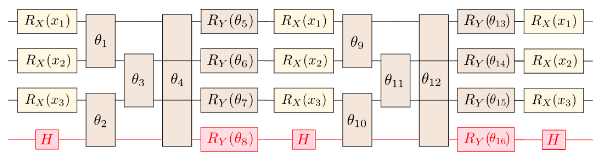

In [ ]:
qaoa_dev = qml.device("default.qubit",wires=range(2))

@qml.qnode(qaoa_dev)
def qaoa_encoder(data,weights):
  qml.QAOAEmbedding(features=data,weights=weights,wires=range(2),local_field="Y")
  return qml.state()

In [ ]:
# define features 
features = [4+2j,5]
# get weights
shape = qml.QAOAEmbedding.shape(n_layers=2,n_wires=2)
print("This is the required shape: ",shape)
weights = np.random.random(shape)
print("Have a look at the weights: ")
print(weights)

This is the required shape:  (2, 3)
Have a look at the weights: 
[[0.83476753 0.38038711 0.26218502]
 [0.83938557 0.35331697 0.44225233]]


In [ ]:
qaoa_encoder(data=features,weights=weights)

tensor([2.8061383 +1.75514429j, 0.00346428-7.5773217j ,
        2.12158434+1.96276329j, 0.18583484-6.76839035j], requires_grad=True)

In [ ]:
print(qml.draw(qnode=qaoa_encoder,expansion_strategy="device")(features,weights))

0: ──RX(4.00+2.00j)─╭MultiRZ(0.83)──RY(0.38)──RX(4.00+2.00j)─╭MultiRZ(0.84)──RY(0.35)
1: ──RX(5.00)───────╰MultiRZ(0.83)──RY(0.26)──RX(5.00)───────╰MultiRZ(0.84)──RY(0.44)

───RX(4.00+2.00j)─┤  State
───RX(5.00)───────┤  State


### Train the Embedding

In [ ]:
qaoa_dev = qml.device("default.qubit",wires=range(2))

@qml.qnode(qaoa_dev)
def trainable_qaoa_encoder(weights,data):
  qml.QAOAEmbedding(weights=weights,features=data,wires=range(2),local_field="Y")
  return qml.expval(qml.PauliZ(0))

In [ ]:
opt = qml.GradientDescentOptimizer()
steps = 10
for i in range(steps):
  weights = opt.step(lambda w: trainable_qaoa_encoder(data=features,weights=w),weights)
  print(f"This is step {i} and weights are {weights}")

This is step 0 and weights are [[0.89044291 0.42938994 0.26478117]
 [0.79474026 0.27438391 0.44225233]]
This is step 1 and weights are [[0.94489863 0.47708312 0.26800971]
 [0.7393744  0.19289975 0.44225233]]
This is step 2 and weights are [[0.99664823 0.52219862 0.27172785]
 [0.67340875 0.1087978  0.44225233]]
This is step 3 and weights are [[1.04398885 0.56336974 0.27573443]
 [0.59742566 0.02212334 0.44225233]]
This is step 4 and weights are [[ 1.08508829  0.59920342  0.27978268]
 [ 0.51242978 -0.06693461  0.44225233]]
This is step 5 and weights are [[ 1.11810732  0.62836414  0.2836037 ]
 [ 0.41975369 -0.15802819  0.44225233]]
This is step 6 and weights are [[ 1.14133618  0.64965239  0.28693744]
 [ 0.32093136 -0.25064893  0.44225233]]
This is step 7 and weights are [[ 1.15332173  0.66206563  0.28956592]
 [ 0.21757548 -0.34413511  0.44225233]]
This is step 8 and weights are [[ 1.15297088  0.66484358  0.29134297]
 [ 0.11129401 -0.43768709  0.44225233]]
This is step 9 and weights are [[ 

## IQPEmbedding 

Data Type --> Int/Float/Complex

Encodes $n$ features into $n$ qubits using diagonal gates of an IQP circuit.

In [ ]:
iqp_dev = qml.device("default.qubit",wires=range(3))

@qml.qnode(iqp_dev)
def iqp_encoder(data):
  qml.IQPEmbedding(data,wires=range(3),n_repeats=1)
  return [qml.expval(qml.PauliZ(q)) for q in range(3)]

In [ ]:
print(qml.draw(qnode=iqp_encoder,expansion_strategy="device")([7,8,9]))

0: ──H──RZ(7.00)─╭MultiRZ(56.00)─╭MultiRZ(63.00)─────────────────┤  <Z>
1: ──H──RZ(8.00)─╰MultiRZ(56.00)─│───────────────╭MultiRZ(72.00)─┤  <Z>
2: ──H──RZ(9.00)─────────────────╰MultiRZ(63.00)─╰MultiRZ(72.00)─┤  <Z>


### Custom Pattern

In [ ]:
custom_pattern = [[0,1],[0,2],[1,2]]
iqp_dev = qml.device("default.qubit",wires=range(3))

@qml.qnode(iqp_dev)
def custom_iqp_encoder(data):
  qml.IQPEmbedding(data,wires=range(3),n_repeats=2,pattern=custom_pattern)
  return [qml.expval(qml.PauliZ(q)) for q in range(3)]

In [ ]:
print(qml.draw(qnode=custom_iqp_encoder,expansion_strategy="device")([7.5,8+0.5j,9]))

0: ──H──RZ(7.50)───────╭MultiRZ(60.00+3.75j)─╭MultiRZ(67.50)──H─────────────────────RZ(7.50)
1: ──H──RZ(8.00+0.50j)─╰MultiRZ(60.00+3.75j)─│───────────────╭MultiRZ(72.00+4.50j)──H───────
2: ──H──RZ(9.00)─────────────────────────────╰MultiRZ(67.50)─╰MultiRZ(72.00+4.50j)──H───────

──────────────────╭MultiRZ(60.00+3.75j)─╭MultiRZ(67.50)───────────────────────┤  <Z>
───RZ(8.00+0.50j)─╰MultiRZ(60.00+3.75j)─│───────────────╭MultiRZ(72.00+4.50j)─┤  <Z>
───RZ(9.00)─────────────────────────────╰MultiRZ(67.50)─╰MultiRZ(72.00+4.50j)─┤  <Z>


## SqueezingEmbedding

Data Type --> Int/Float/Complex

Encodes N features into the squeezing amplitudes r≥0 or phases 
ϕ∈[0,2π) of M modes, where N≤M.


$S(z) = exp(\frac{1}{2}(z^{*}\hat{a}^2-z\hat{a}^{\dagger2}))$

$ z= re^{i\phi} $

$$S(z) = exp(\frac{r}{2}(e^{-i\phi}\hat{a}^2-e^{i\phi}\hat{a}^{\dagger2}))$$

In [ ]:
s_dev = qml.device("default.gaussian",wires=range(3))

@qml.qnode(s_dev)
def s_encoder(data):
  qml.SqueezingEmbedding(data,wires=range(3),method='amplitude',c=0.1)
  qml.QuadraticPhase(0.1,wires=1)
  return qml.expval(qml.NumberOperator(wires=1))

In [ ]:
print(qml.draw(s_encoder)([4,5,6]))

0: ─╭SqueezingEmbedding(M0)──────────┤     
1: ─├SqueezingEmbedding(M0)──P(0.10)─┤  <n>
2: ─╰SqueezingEmbedding(M0)──────────┤     


## References

* [Video by Parth G on Ladder Operators](https://youtu.be/ocJBIXua6zQ)

* [Video by Professor M does Science on Boson Creation & Boson Annihilation Operators](https://youtu.be/BhK6u0bMqG0)

* [QAOA Explained by Qiskit](https://qiskit.org/textbook/ch-applications/qaoa.html)

* [IQP Embedding Paper](https://arxiv.org/abs/1804.11326)

* [Quantum Computing Projects](https://youtube.com/playlist?list=PLJk_IGUjQllcYPHhuzIUZMsu9hD48BiK0)

* [Visually Understanding Quantum Computing](https://youtube.com/playlist?list=PLJk_IGUjQllcYPHhuzIUZMsu9hD48BiK0)

* [Pennylane Documentation](https://docs.pennylane.ai/en/stable/introduction/templates.html)

## Follow for more

[Join the telegram channel](https://t.me/ml_qml)

[YouTube Channel](https://www.youtube.com/c/BlochSphere)